/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Vettore delle features (1000 elementi):
[-7.85873830e-01  5.07414162e-01 -1.14175487e+00  4.88380909e-01
 -1.78083444e+00  1.18951023e+00 -1.02473927e+00 -2.28448844e+00
 -2.69637251e+00 -2.10754681e+00 -1.08666158e+00 -3.02269459e+00
 -2.76979506e-01 -2.58168578e+00 -5.41612387e-01 -2.57497931e+00
 -5.80288792e+00 -2.74823594e+00 -3.14791059e+00 -1.20365763e+00
 -4.06452942e+00 -3.28168511e+00 -3.82785702e+00 -2.95967007e+00
 -9.75165725e-01 -1.66422331e+00 -1.80501485e+00 -5.38848042e-01
 -2.23118171e-01 -1.20048535e+00 -1.68774158e-01 -9.00957286e-02
 -1.25820339e-02  6.67219281e-01  1.12959099e+00  2.13531470e+00
  2.97019958e+00  1.47963226e+00 -2.85520136e-01 -2.55953097e+00
 -1.78402555e+00 -1.77693939e+00 -3.84063864e+00 -6.50915265e-01
 -1.66515076e+00 -1.60825491e+00 -2.63458800e+00 -1.98807538e-01
 -2.15112638e+00 -1.33470047e+00 -1.06425977e+00  2.84985590e+00
 -7.38313973e-01 -1.18052435e+00 -2.03516531e+00 -2.83122659e+00
 -4.46235657e+00 -3.17168522e+00 -2.44956255e+00  

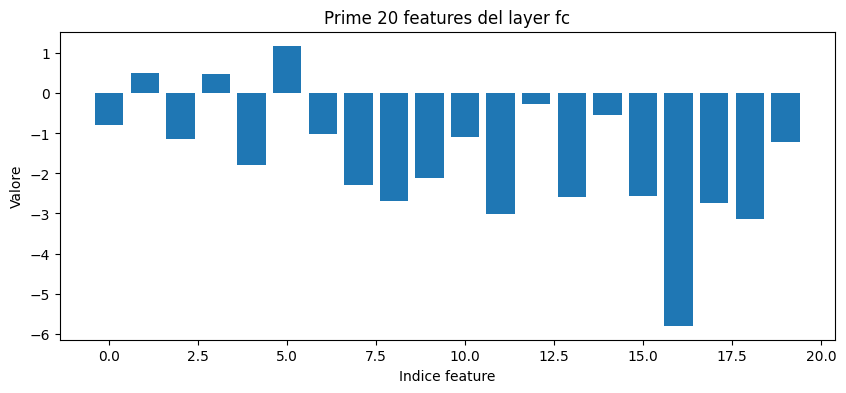

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

def extract_resnet_fc_features(img_path):
    # Carica l'immagine e assicura la modalità RGB
    img = Image.open(img_path).convert('RGB')
    
    # Pre-processamento standard per ResNet: ridimensiona, ritaglia, trasforma in tensor e normalizza
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img).unsqueeze(0)  # Aggiungi la dimensione del batch
    
    # Carica la ResNet50 pre-addestrata e mettila in modalità eval
    resnet = models.resnet50(pretrained=True)
    resnet.eval()
    
    # Lista per salvare l'output del layer fc
    fc_output = []

    # Definisci un hook che memorizza l'output del layer fc
    def hook_fn(module, input, output):
        fc_output.append(output)
    
    # Registra il forward hook sul layer fully connected
    hook = resnet.fc.register_forward_hook(hook_fn)
    
    # Passa l'immagine attraverso il modello
    with torch.no_grad():
        resnet(img_tensor)
    
    # Rimuovi l'hook (è buona norma pulirlo dopo l'uso)
    hook.remove()
    
    # Il risultato è salvato in fc_output[0] con shape [1, 1000]. Rimuovi la dimensione del batch:
    features = fc_output[0].squeeze(0)
    
    # Stampa e visualizza il vettore delle features
    print("Vettore delle features (1000 elementi):")
    print(features.numpy())
    
    # Visualizzazione opzionale: ad esempio, un bar plot dei primi 20 valori
    plt.figure(figsize=(10, 4))
    plt.bar(range(20), features.numpy()[:20])
    plt.xlabel("Indice feature")
    plt.ylabel("Valore")
    plt.title("Prime 20 features del layer fc")
    plt.show()
    
    return features

# Esempio di esecuzione
img_path = "Part1/brain_glioma/brain_glioma_0002.jpg"  # Sostituisci con il percorso corretto della tua immagine
features = extract_resnet_fc_features(img_path)


Task: 2

In [2]:
import os
import csv
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

def extract_fc_features_from_image(image_path, model, preprocess, device):
    """
    Apre l'immagine, la pre-processa e la passa attraverso la rete.
    Utilizza un hook per catturare l'output del layer fully connected (fc) della ResNet.
    Restituisce un vettore numpy di dimensione 1000.
    """
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Errore nell'apertura dell'immagine {image_path}: {e}")
        return None

    img_tensor = preprocess(img).unsqueeze(0).to(device)
    
    fc_output = []

    # Definizione del hook per catturare l'output del layer fc
    def hook_fn(module, input, output):
        fc_output.append(output)

    hook = model.fc.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(img_tensor)
    hook.remove()

    # fc_output[0] ha forma [1, 1000], rimuoviamo la dimensione batch e riportiamo su CPU
    features = fc_output[0].squeeze(0).cpu().numpy()
    return features

def main():
    # Imposta il percorso della cartella base e le sottocartelle
    base_dir = "Part1"
    subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp")

    image_paths = []
    # Cerca le immagini all'interno delle sottocartelle specificate
    for sub in subfolders:
        dir_path = os.path.join(base_dir, sub)
        if os.path.isdir(dir_path):
            for root, _, files in os.walk(dir_path):
                for file in files:
                    if file.lower().endswith(image_extensions):
                        image_paths.append(os.path.join(root, file))
        else:
            print(f"La cartella {dir_path} non esiste.")

    if not image_paths:
        print("Non sono state trovate immagini nelle cartelle specificate.")
        return

    # Configura il dispositivo da utilizzare (GPU se disponibile, altrimenti CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Definisci la trasformazione di pre-processing standard per ResNet
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # Carica il modello ResNet50 pre-addestrato ed impostalo in modalità evaluation
    model = models.resnet50(pretrained=True)
    model.eval()
    model.to(device)


    """""
    # Prepara i dati che verranno salvati sul file CSV
    csv_rows = []
    # Crea l'header: la prima colonna è il percorso dell'immagine, le altre sono le feature
    header = ["image_path"] + [f"fc_feature_{i}" for i in range(1000)]
    csv_rows.append(header)

    # Estrai le features per ogni immagine e conserva il risultato in una riga di CSV
    for img_path in image_paths:
        features = extract_fc_features_from_image(img_path, model, preprocess, device)
        if features is not None:
            row = [img_path] + features.tolist()
            csv_rows.append(row)
        else:
            print(f"Errore nell'estrazione delle features da {img_path}")

    # Salva i risultati in un file CSV
    csv_file = "resnetfc.csv"
    try:
        with open(csv_file, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(csv_rows)
        print(f"Salvataggio completato in {csv_file}")
    except Exception as e:
        print(f"Errore durante il salvataggio del file CSV: {e}")

if __name__ == "__main__":
    main()
"""

# === Funzione per elaborare immagini in più cartelle ===
def process_and_save_features(base_folder, subfolders, output_file):
     # Carica il modello ResNet50 pre-addestrato ed impostalo in modalità evaluation
    model = models.resnet50(pretrained=True)
    model.eval()
    model.to(device)

    all_features = []
    all_filenames = []
    all_labels = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_fc_features_from_image(img_path, model, preprocess, device)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    # Converti in array
    features_array = np.array(all_features)
    filenames_array = np.array(all_filenames)
    labels_array = np.array(all_labels)

    # Salva in .npz
    np.savez(output_file, features=features_array, filenames=filenames_array, labels=labels_array)
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")


# === Esecuzione ===
base_folder = "Part1"
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
output_file = "features_cm10x10.npz"

process_and_save_features(base_folder, subfolders, output_file)

Salvataggio completato in resnetfc.csv


In [5]:
from torchvision import models
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.eval()
model.to(device)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
import os
import csv
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

def extract_fc_features_from_image(image_path, model, preprocess, device):
    """
    Apre l'immagine, la pre-processa e la passa attraverso la rete.
    Utilizza un hook per catturare l'output del layer fully connected (fc) della ResNet.
    Restituisce un vettore numpy di dimensione 1000.
    """
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"[ERRORE] Immagine non valida {image_path}: {e}")
        return None

    img_tensor = preprocess(img).unsqueeze(0).to(device)
    
    fc_output = []

    def hook_fn(module, input, output):
        fc_output.append(output)

    hook = model.fc.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(img_tensor)
    hook.remove()

    if fc_output:
        return fc_output[0].squeeze(0).cpu().numpy()
    else:
        print(f"[ERRORE] Nessun output FC per {image_path}")
        return None

def process_and_save_features(base_folder, subfolders, output_file):
    # Configura il dispositivo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Definisci la trasformazione
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # Carica il modello
    model = models.resnet50(pretrained=True)
    model.eval()
    model.to(device)

    all_features = []
    all_filenames = []
    all_labels = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        if not os.path.isdir(folder_path):
            print(f"[ATTENZIONE] Cartella non trovata: {folder_path}")
            continue
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_fc_features_from_image(img_path, model, preprocess, device)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)
                else:
                    print(f"[ERRORE] Feature non estratte da {img_path}")

    # Converti in array
    features_array = np.array(all_features)
    filenames_array = np.array(all_filenames)
    labels_array = np.array(all_labels)

    # Salva in .npz
    np.savez(output_file, features=features_array, filenames=filenames_array, labels=labels_array)
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")

# === Esecuzione ===
if __name__ == "__main__":
    base_folder = "Part1"
    subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
    output_file = "resnetfc.npz"

    process_and_save_features(base_folder, subfolders, output_file)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnetfc.npz
[FINE] Totale immagini processate: 3006



Top 5 immagini più simili (distanza coseno) a: Part1/brain_glioma/brain_glioma_0005.jpg
1. brain_glioma_0005.jpg | Classe: brain_glioma | Distanza: 0.0000
2. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 0.0204
3. brain_glioma_0071.jpg | Classe: brain_glioma | Distanza: 0.0206
4. brain_glioma_0311.jpg | Classe: brain_glioma | Distanza: 0.0212
5. brain_glioma_0564.jpg | Classe: brain_glioma | Distanza: 0.0439


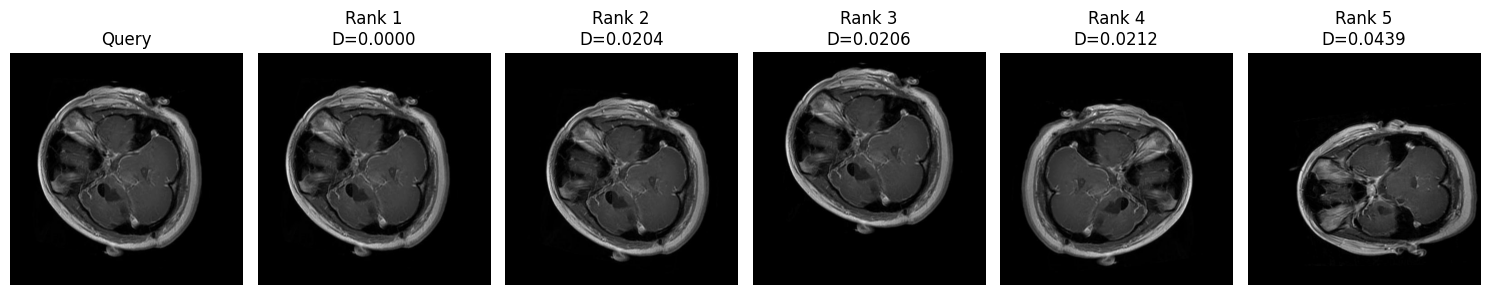

In [14]:
from sklearn.metrics.pairwise import cosine_distances

# Carica dati da file .npz (con feature ResNetFC)
data = np.load("resnetfc.npz", allow_pickle=True)
feature_matrix = data["features"]
filenames = data["filenames"]
labels = data["labels"]

# Definisci la trasformazione
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# === Funzione per trovare k immagini più simili (coseno) ===
def find_k_similar_cosine(img_path, k):
    query_feature = extract_fc_features_from_image(img_path, model, preprocess, device)  # Deve restituire un vettore 1D
    if query_feature is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    # Calcola la distanza del coseno (1 - similarità coseno)
    distances = cosine_distances(feature_matrix, query_feature).flatten()

    top_k_idx = np.argsort(distances)[:k]
    top_k_scores = distances[top_k_idx]

    print(f"\nTop {k} immagini più simili (distanza coseno) a: {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Distanza: {top_k_scores[rank]:.4f}")

    # Visualizza risultati
    fig, axs = plt.subplots(1, k+1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        match_img = cv2.imread(os.path.join("Part1", labels[idx], filenames[idx]))
        axs[i+1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f"Rank {i+1}\nD={top_k_scores[i]:.4f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

# === Test ===
query_img = "Part1/brain_glioma/brain_glioma_0005.jpg"
find_k_similar_cosine(query_img, k=5)